In [5]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe
from torch import nn
import spacy
import numpy as np

In [7]:
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, fix_length=150)
LABEL = data.Field(sequential=False, use_vocab=True)

In [10]:
pos = data.TabularDataset(
    path='./IMDB Dataset.csv', format='csv',skip_header = True,
    fields=[('text', TEXT),
        ('labels', LABEL)])

In [11]:
TEXT.build_vocab(pos, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(pos)

In [12]:
print(len(pos))

50000


In [13]:
train_iter = data.BucketIterator(pos,batch_size=500, shuffle = True)

In [14]:
print(type(train_iter))

<class 'torchtext.data.iterator.BucketIterator'>


In [15]:
batch = next(iter(train_iter))

print((batch))
print(batch.text)
print(batch.labels)
print(len(batch.labels))


[torchtext.data.batch.Batch of size 500]
	[.text]:[torch.LongTensor of size 150x500]
	[.labels]:[torch.LongTensor of size 500]
tensor([[ 1041,  7030,    13,  ..., 29125,   746,    13],
        [ 1785,    16,    23,  ..., 12553,    92,     9],
        [   66,   102,     9,  ...,     3,  1258,     6],
        ...,
        [  143,    22,     1,  ..., 35464,     2,    41],
        [29738,  3416,     1,  ...,   231, 10677,  3546],
        [   87,     5,     1,  ...,  8191,     4,   897]])
tensor([2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
        2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2,
        2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2,
        1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2,
        2, 1, 2, 1, 2, 2, 2, 1

In [16]:
# Embedding layer
emb_dim = 300
vocab = TEXT.vocab
print(len(vocab))
embed = nn.Embedding(len(vocab), emb_dim)
print(vocab.vectors.shape)
print(embed)
print(len(vocab.vectors))
print(embed.weight.data.copy_(vocab.vectors))

146591
torch.Size([146591, 300])
Embedding(146591, 300)
146591
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.3058,  0.1605, -1.0598,  ..., -0.1416,  0.2696,  0.2385],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [17]:
print(type(vocab), next(iter(vocab)), type(vocab.itos[0]))

<class 'torchtext.vocab.Vocab'> 0 <class 'str'>


In [18]:
print(type(embed), embed.weight, len(embed.weight[0]))

<class 'torch.nn.modules.sparse.Embedding'> Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.3058,  0.1605, -1.0598,  ..., -0.1416,  0.2696,  0.2385],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True) 300


In [19]:
print(type(embed.weight.data), type(np.array(embed.weight.data)))

<class 'torch.Tensor'> <class 'numpy.ndarray'>


In [20]:
print(vocab['bad'], vocab['shit'])

93 39221


In [65]:
"""
def PCA_svd(X, k, center=True):
    n = X.size()[0]
    ones = torch.ones(n).view([n,1])
    h = ((1/n) * torch.mm(ones, ones.t())) if center  else torch.zeros(n*n).view([n,n])
    H = torch.eye(n) - h
    X_center =  torch.mm(H.double(), X.double())
    u, s, v = torch.svd(X_center) 
    components  = v[:k].t()
    explained_variance = torch.mul(s[:k], s[:k])/(n-1)
    return { 'X':X, 'k':k, 'components':components,     
            'explained_variance':explained_variance }
PCA_svd(embed)
"""
from sklearn.manifold import TSNE
x_tsne = TSNE(init = 'pca', n_components = 2, random_state=23).fit_transform(embed.weight[200:800].detach().squeeze(-1))

In [52]:
print("Org data dimension is {}. Embedded data dimension is {}".format(embed.weight.shape[-1], x_tsne.shape[-1]))


Org data dimension is 300. Embedded data dimension is 2


In [56]:
#print(x_tsne)

In [63]:
def plt_with_scatter(data,label,title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    #歸一化
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(data)):
        plt.text(data[i,0],data[i,1],str(label[i]), fontdict = {'weight':'black', 'size':'x-large'})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig
#參考 : https://www.deeplearn.me/2137.html

In [48]:
print(vocab.itos[:3])

['<unk>', '<pad>', 'the']


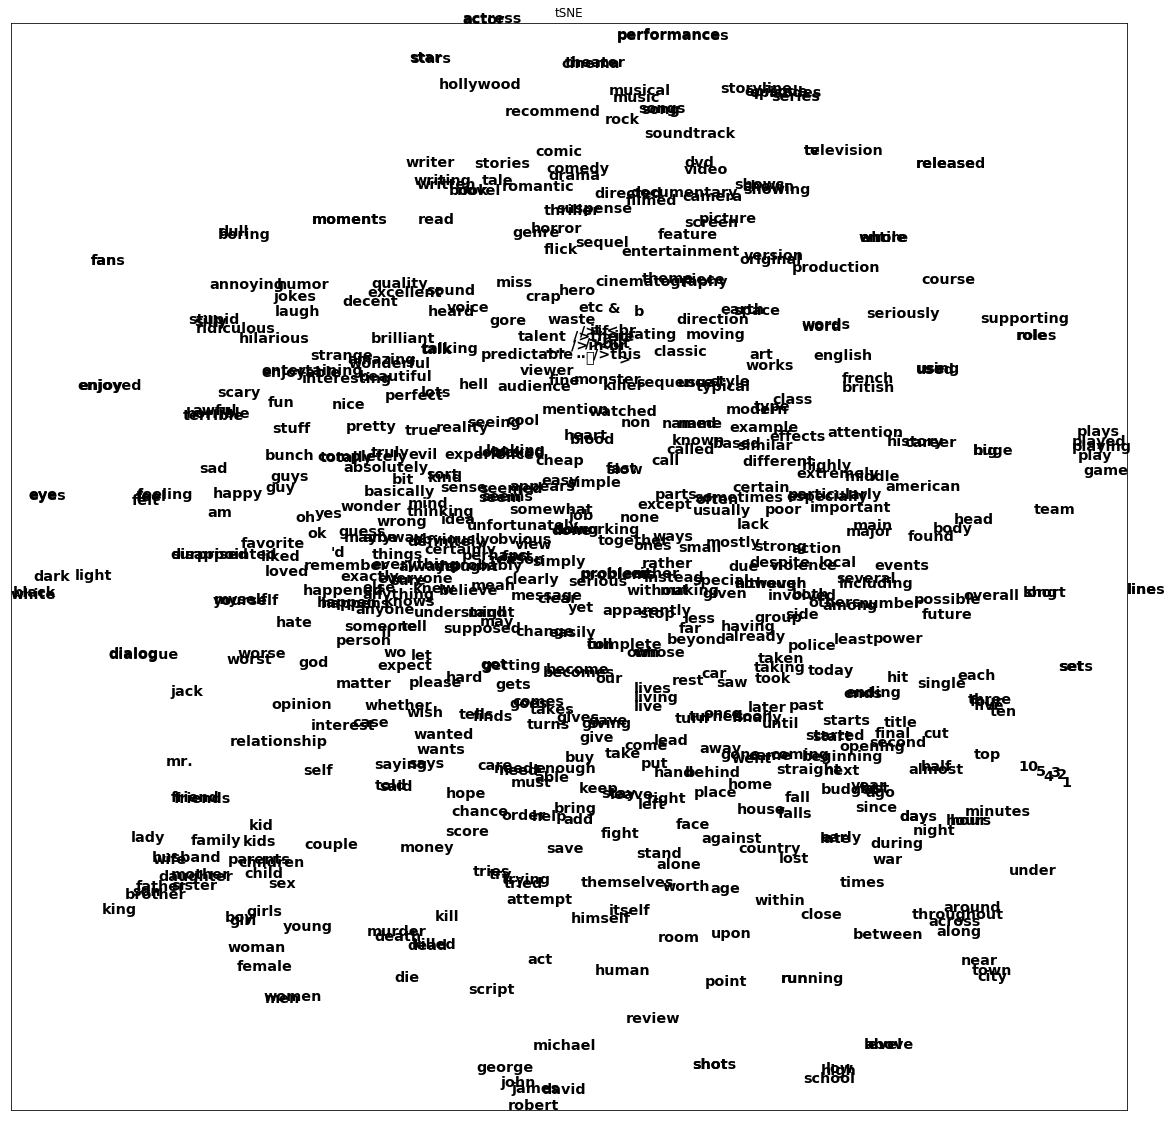

In [67]:
import matplotlib.pyplot as plt
fig = plt_with_scatter(x_tsne,vocab.itos[200:800], 'tSNE')
plt.show(fig)